# <font color=#FF1493>Bio-Inspired Learning</font>

## <font color=#FF69B4>Differential Evolution for finding the Best Neural Network arquitecture</font>
* #### For classical: **Titanic Survival Prediction**


---
* #### <font color=#F5F5D6>This is a Kaggle Notebook [Laura Fink: Differential Evolution](https://www.kaggle.com/code/allunia/differential-evolution/notebook?scriptVersionId=51573719)
</font>

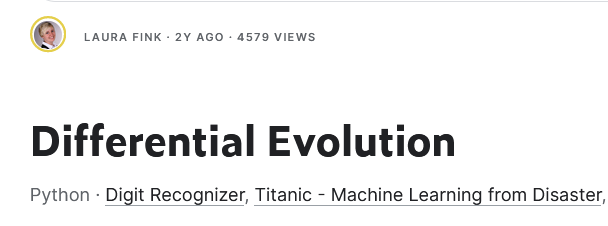
---
---
### <font color=#C0C0C0>Master of Science in Signal Theory and Communications (MUTSC)</font>
### *Signal processing and machine learning for big data*
## <font color=orange>ETSIT - UPM</font>
---

# Why is it worth it?

Our world is **highly dynamic** and even if we find periodic patterns we can't assume that they will stay there forever. When we just train models on data that was collected in the past and apply them only for inference on future data we will likely experience a break-down of our evaluation criteria someday. Especially the pandemic of covid-19 should have opened the eyes that **stochastic events can cause changes in the overall system that are not easy to foresee and/or somehow irrational. In such cases machine learning models that are not able to adapt to environmental changes like a chameleon are doomed to fail.**


With this notebook I like to learn more about evolutionary algorithms and share my experiences with the community. If you like to play with code and ideas, just fork. ;-)

Happy kaggling!


<img src="https://cdn.pixabay.com/photo/2020/01/10/21/07/terrarium-4756280_1280.jpg" width="900px">

## Table of contents

1. [What is Differential Evolution?](#differential_evolution)
2. [How does it work?](#how)
3. [Code to built the model](#de_model)
4. [Some simple examples](#simple_examples)
5. [Prepare for the Titanic](#prepare_titanic)
6. [Build the NNs for Titanic](#nn_titanic)
7. [Build an individual for DE](#individual)
8. [Differential Evolution for Titanic](#de_titanic)
9. [Understanding the evolution of hyperparameters](#de_hyperpar_evolution)
10. [Hyperparameter evolution for digits and flowers dataset](#de_digits_and_flowers)
11. [Conclusion](#conclusion)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import FixedLocator, MaxNLocator
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='html5')

from tensorflow import keras

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# What is Differential Evolution? <a class="anchor" id="differential_evolution"></a>

* An evolutionary algorithm based on a popultion of models/individuals.
* It's able to find global optima in optimisation landscapes with many local minima.
* It recombines one individual of the population with a new candidate **(trial)** that is obtained by computing the difference between two further individuals in the population.
* By computing these so called difference vectors the algorithm is able to self-adapt the stepsize for exploiting the parameter space of the optimisation.  
* It can also be applied in settings where there is no optimisation function at all but some kind of feedback how good the result is.
* It can also deal with optimisation landscapes that change over time.

# How does it work? <a class="anchor" id="how"></a>

Let's directly use an example by tuning the hyperparameters of neural networks.

* For this kind of optimisation the function is unknown. We have no mathematical equation that tells us how the scores or error losses behave when we change the learning rate or increase the dropout rate etc.. 
* In this problem setup, each set of parameters we could chose for a neural network is one individual. When we initialize different parameter sets then we obtain our first population.

Now the following recipe has to be followed! ;-)

1. Generate mutant using three different individuals $p_{i}$:

    * $ \vec{m} = \vec{p}_{A} - s \cdot \left( \vec{p}_{B}-\vec{p}_{C} \right)$
2. Compute a trial individual $\vec{c}$ by doing crossover using the mutant $\vec{m}$ and a randomly selected target individual $\vec{t}$:

    * $ \vec{c} = copy \left( \vec{t} \right) $
    * Randomly select elements $c_{i}$ for being replaced with the mutant element $m_{i}$:
   
    $$c_{i}=\begin{cases}
  m_{i},  & \text{if } r R\\
  c_{i}, & \text{else }
\end{cases}$$
    
    
3. Compute losses of trials and parents.
4. Perform selection by comparing trials and parents and choosing the best for the next generation.
5. Redo until stopping criertion has been reached. 

# Code to built the model <a class="anchor" id="de_model"></a>

In [2]:
class DifferentialEvolution:

    def __init__(self, scaling_rate, crossover_rate, population_size):
        self.scaling_rate = scaling_rate
        self.crossover_rate = crossover_rate
        self.population_size = population_size
        self.ranges = []
        
        self.generation_counter = 0
        
        self.all_generations = []
        self.min_std_criterion = 0.001
    
    def set_range(self, paramkey, range):
        self.ranges.append([paramkey, range])
    
    def set_objective(self, objective):
        self.objective = objective
    
    def init_generation(self):
        self.n_params = len(self.ranges)
        self.generation = np.zeros(shape=(self.population_size, self.n_params))
        for p in range(self.n_params):
            low = self.ranges[p][1][0]
            high = self.ranges[p][1][1]
            self.generation[:, p] = np.random.uniform(low, high, size=self.population_size)
    
    def get_trials(self):
        self.trials = np.zeros(shape=(self.population_size, self.n_params))
        for i in range(self.population_size):
            target = self.generation[i, :]
            mutant = self.mutate(i)
            self.trials[i, :] = self.crossover(mutant, target)
    
    def get_candidates(self, i):
        to_select = list(np.arange(self.population_size))
        to_select.remove(i)
        candidates = np.random.choice(to_select, 3, replace=False)
        return candidates
    
    def mutate(self, i):
        candidates = self.get_candidates(i)
        difference_vector = self.generation[candidates[1]] - self.generation[candidates[2]]
        mutant = self.generation[candidates[0]] + self.scaling_rate * difference_vector
        return mutant
    
    def crossover(self, mutant, target):
        crossover_units = np.random.uniform(0, 1, self.n_params)
        trial = np.copy(target)
        random_parameter = np.random.choice(self.n_params)
        for param in range(self.n_params):
            if crossover_units[param] <= self.crossover_rate or param == random_parameter:
                trial[param] = mutant[param]
        return trial
    
    def select(self, generation_costs, trials_costs):
        idx = np.where(trials_costs < generation_costs)[0]
        for i in idx:
            self.generation[i, :] = self.trials[i, :]

    def compute_cost(self):
        generation_costs = self.objective(self.generation)
        trials_cost = self.objective(self.trials)
        return generation_costs, trials_cost
    
    def evolve(self):
        self.init_generation()
        self.all_generations.append(self.generation)
        self.best_solutions = []
        gen_costs = self.objective(self.generation)
        while ((np.std(gen_costs) > self.min_std_criterion) and (self.generation_counter < 200)):
            self.get_trials()
            gen_costs, trials_costs = self.compute_cost()
            self.select(gen_costs, trials_costs)
            self.all_generations.append(np.copy(self.generation))
            self.generation_counter += 1
            self.best_solutions.append(np.min(gen_costs))
        print("Stopped at generation {}".format(self.generation_counter))

# Some simple examples <a class="anchor" id="simple_examples"></a>

Let's get a first feeling about how this algorithm works and abouts its performance by searching for optima in the parameter space of:

* the rosenbrock function (coming soon)
* the griewank function
* the himmelblau function

Just use an example of your choice and watch Differential Evolution during optimisation.

In [3]:
example = "griewank"

In [4]:
def rosenbrock(w, a=1, b=100):
    return np.power(a-w[:,0],2)+b*np.power(w[:,1]-w[:,0]**2, 2)

def griewank(w):
    sum_part = np.zeros(w.shape[0])
    cos_part = np.ones(w.shape[0])
    for i in range(w.shape[1]):
        sum_part += np.power(w[:, i], 2)
        cos_part *= np.cos(w[:, i] / np.sqrt(i+1))
    return np.ones(w.shape[0]) + 1/4000 * sum_part - cos_part


def himmelblau(w):
    part1 = np.power(np.power(w[:, 0], 2) + w[:, 1] - 11, 2)
    part2 = np.power(w[:, 0] + np.power(w[:, 1], 2) - 7, 2)
    return part1 + part2    


examples = {"rosenbrock": {"objective": rosenbrock, "range": [-2,3], "delta": 0.1}, 
              "himmelblau": {"objective": himmelblau, "range": [-6, 6], "delta": 0.1},
              "griewank": {"objective": griewank, "range": [-50, 50], "delta": 0.5}}

In [5]:
class ShowEvolution:

    def __init__(self, example):
        self.model = DifferentialEvolution(scaling_rate=0.7, crossover_rate=0.6, population_size=15)
        self.example = example
        self.range = examples[example]["range"]
        self.objective = examples[example]["objective"]
        self.delta = examples[example]["delta"]
        self.model.set_objective(self.objective)
        self.model.set_range("w1", self.range)
        self.model.set_range("w2", self.range)
        self.model.evolve()

        self.dx, self.dy = self.delta, self.delta

        tau = np.mgrid[slice(self.range[0], self.range[1] + self.dy, self.dy),
                       slice(self.range[0], self.range[1] + self.dx, self.dx)]

        self.X = tau[0, :-1, :-1]
        self.Y = tau[1, :-1, :-1]
        self.Z = np.zeros(shape=(tau.shape[1], tau.shape[2]))
        
        for m in range(tau.shape[1]):
            for n in range(tau.shape[2]):
                self.Z[n, m] = self.objective(tau[:, n, m].reshape(1, -1))

    def show(self):
        self.fig, self.ax = plt.subplots()
        self.make_nice_contours(self.ax, self.fig)

        self.ani = animation.FuncAnimation(self.fig, self.update,
                                           init_func=self.setup_plot,
                                           frames=np.arange(len(self.model.all_generations)),
                                           interval=50,
                                           blit=True,
                                           repeat=False)
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        self.ani.save('example.mp4', writer=writer)
        plt.close()
        return self.ani
        
        
    def make_nice_contours(self, ax, fig):
        Z = self.Z[:-1, :-1]
        
        if self.example == "griewank":
            levels = MaxNLocator(nbins=50).tick_values(Z.min(), Z.max())
            
        else:
            levels = FixedLocator([0.05, 0.1, 0.25, 0.5, 1, 2.5, 5 , 7.5,
                                   10, 20, 40, 80, 160, 320, 640, 1280]).tick_values(vmin=0, vmax=1280)
            
        cmap = plt.get_cmap('coolwarm')
        norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

        cf = ax.contourf(self.X + self.dx / 2., self.Y + self.dy / 2., Z,
                         levels=levels,
                         cmap=cmap,
                         norm=norm)
        ax.set_xlabel("$p_{1}$")
        ax.set_ylabel("$p_{2}$")
        return plt
    
    def update(self, i):
        """Update the scatter plot."""
        data = self.model.all_generations[i]
        self.scat.set_offsets(data)
        return self.scat,

    def setup_plot(self):
        data = self.model.all_generations[0]
        x = data[:, 0]
        y = data[:, 1]
        self.scat = self.ax.scatter(x, y, c="black", marker='o', s=15)
        self.ax.set_xlim([self.range[0], self.range[1]])
        self.ax.set_ylim([self.range[0], self.range[1]])
        return self.scat,

In [6]:
gwc = ShowEvolution(example)
gwc.show()

Stopped at generation 112


# Prepare the Titanic <a class="anchor" id="prepare_titanic"></a>

Ok, let's start simple by building a feedforward neural network to classify the survival of the titanic. As I don't want to win this competition but rather to show what you can do with Differential Evolution I like to reduce the feature space by only using:

* Pclass
* Sex
* Age
* Embarked
* Fare
* Family size

It should be sufficient. 

In [7]:
!wget "https://raw.githubusercontent.com/pcsanwald/kaggle-titanic/master/train.csv"

--2023-04-20 10:04:20--  https://raw.githubusercontent.com/pcsanwald/kaggle-titanic/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57726 (56K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  56.37K  --.-KB/s    in 0.006s  

2023-04-20 10:04:20 (9.63 MB/s) - ‘train.csv’ saved [57726/57726]



In [8]:
titanic = pd.read_csv("train.csv")
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have to be careful with the fare as it is a price per group/family and not per person. You can see that every family member given by the lastname and the ticket has the same fare (std of 0):

In [9]:
titanic.loc[:, "lastname"] = titanic.name.str.split(",").apply(lambda l: l[0])
titanic.groupby(["lastname","ticket"]).fare.std().fillna(0).max()

0.0

In [10]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,lastname
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Braund
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cumings
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Heikkinen
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Futrelle
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Allen


Now we can compute the price per person which should work better together with features like Pclass. Otherwise we would conclude for big families that a high price corresponds to a higher Pclass.

In [11]:
price_map = titanic.groupby(["lastname", "ticket"]).fare.min() / titanic.groupby(["lastname", "ticket"]).size()
family_size_map = titanic.groupby(["lastname", "ticket"]).size()
titanic = titanic.set_index(["lastname", "ticket"], drop=True)
titanic.loc[:, "price"] = titanic.index.map(price_map)
titanic.loc[:, "family_size"] = titanic.index.map(family_size_map)
titanic = titanic.reset_index()

Ok, let's get one-hot encoded values for Pclass, Embarked and Sex:

In [12]:
titanic = pd.get_dummies(titanic, columns=["pclass", "embarked", "sex"])

And fill missing ages with median:

In [13]:
titanic.age = titanic.age.fillna(titanic.age.median())

Furthermore we need to transform Age and price such that they look more normally distributed. The gradients of neural networks are direclty influenced by the features themselves and can be misled when outliers are present.

<ipython-input-14-7a66bf54e12b>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(titanic.age, ax=ax[0], color="Orange")
<ipython-input-14-7a66bf54e12b>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(titanic.age.apply(lambda l: np.log(l+20)), ax=ax[1], color="Orange")
<ipython-input-14-7a66bf54

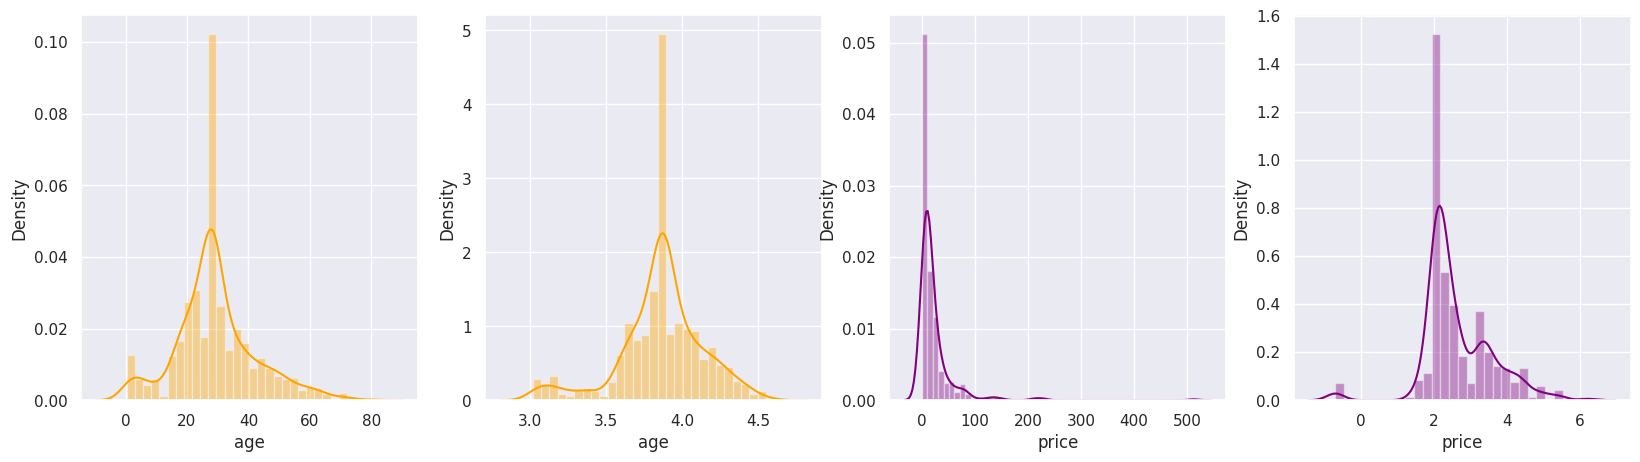

In [14]:
fig, ax = plt.subplots(1,4,figsize=(20,5))
sns.distplot(titanic.age, ax=ax[0], color="Orange")
sns.distplot(titanic.age.apply(lambda l: np.log(l+20)), ax=ax[1], color="Orange")
sns.distplot(titanic.price, ax=ax[2], color="Purple")
sns.distplot(titanic.price.apply(lambda l: np.log(l+0.5)), ax=ax[3], color="Purple");

In [15]:
titanic.age = titanic.age.apply(lambda l: np.log(l+20))
titanic.price = titanic.price.apply(lambda l: np.log(l+0.5))

In [16]:
titanic.columns

Index(['lastname', 'ticket', 'survived', 'name', 'age', 'sibsp', 'parch',
       'fare', 'cabin', 'price', 'family_size', 'pclass_1', 'pclass_2',
       'pclass_3', 'embarked_C', 'embarked_Q', 'embarked_S', 'sex_female',
       'sex_male'],
      dtype='object')

In [17]:
to_drop = [ "ticket", "lastname", "sex_male", "name", "sibsp", "parch", "cabin", "fare"]
titanic = titanic.drop(to_drop, axis=1)
titanic.head()

,survived,age,price,family_size,pclass_1,pclass_2,pclass_3,embarked_C,embarked_Q,embarked_S,sex_female
0,0,3.737670,2.047693,1,0,0,1,0,0,1,0
1,1,4.060443,4.273652,1,1,0,0,1,0,0,1
2,1,3.828641,2.131203,1,0,0,1,0,0,1,1
3,1,4.007333,3.297687,2,1,0,0,0,0,1,1
4,0,4.007333,2.145931,1,0,0,1,0,0,1,0


Ok, that's it! :-) Let's now build a simple neural network and define the hyperparameters we like to tune using Differential Evolution.

In [18]:
num_titanic_features=titanic.drop("survived", axis=1).shape[1]
num_titanic_features

10

# Build the NNs for Titanic <a class="anchor" id="nn_titanic"></a>

Ok, we have optimised some test optimisation functions to see how differential evolution solves the task. Now I like to explore how it will solve hyperparameter tuning for a simple feedforward neural network. I'm especially interested in:

* The number of neurons compared to regularisation given by dropout rates or weight regularisation.
* The number of epochs compared to the learning rate.

Let's go! :-)

In [19]:
def build_titanic_nn(num_neurons_1, dropout_1,
                     num_neurons_2, dropout_2,
                     input_shape=(num_titanic_features,)):
    
    model = keras.Sequential()
    model.add(keras.Input(shape=input_shape))
    model.add(keras.layers.Dense(num_neurons_1, activation="relu"))
    model.add(keras.layers.Dropout(dropout_1))
    model.add(keras.layers.Dense(num_neurons_2, activation="relu"))
    model.add(keras.layers.Dropout(dropout_2))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    return model

# Build an individual for DE <a class="anchor" id="individual"></a>



Before we can use Differential Evolution to search for the best neural network hyperparameters, we need a class for individual neural networks that captures the logic for training and evaluating each net and for storing its parameters:

In [20]:
from collections import OrderedDict
import copy

class Individual_Titanic:
    
    def __init__(self, params):
        self.parameters = copy.deepcopy(params)
        self.history = None
    
    def init_current(self, r_state):
        next_state = 0
        for par in self.parameters.keys():
            state = r_state + next_state
            if self.parameters[par]["val_range"].dtype == int:
                self.parameters[par]["current"] = np.random.RandomState(state).randint(
                    low=self.parameters[par]["val_range"][0],
                    high=self.parameters[par]["val_range"][1]) 
            else:
                self.parameters[par]["current"] = np.random.RandomState(state).uniform(
                    low=self.parameters[par]["val_range"][0],
                    high=self.parameters[par]["val_range"][1])
            next_state += 1
            
    
    def build_model(self):
        model = build_titanic_nn(num_neurons_1=self.parameters["num_neurons_1"]["current"],
                                 dropout_1=self.parameters["dropout_1"]["current"],
                                 num_neurons_2=self.parameters["num_neurons_2"]["current"],
                                 dropout_2=self.parameters["dropout_2"]["current"])
        return model
        
        
    def train(self, x_train, y_train, x_dev, y_dev, verbose = 0):
        model = self.build_model()
        model.compile(loss=keras.losses.BinaryCrossentropy(),
                      optimizer = keras.optimizers.Adam(learning_rate=self.parameters["lr"]["current"]),
                      metrics=["accuracy"])
        self.history = model.fit(x_train, y_train,
                                 batch_size=32,
                                 epochs=self.parameters["epochs"]["current"],
                                 verbose=verbose,
                                 workers=4)
        dev_loss, dev_acc = model.evaluate(x_dev, y_dev)
        self.score = dev_acc
        self.loss = dev_loss
        del model
        

In [21]:
X = titanic.drop("survived", axis=1).values
Y = titanic.survived.values
x_train, x_dev, y_train, y_dev = train_test_split(X, Y, stratify=Y, random_state=0)
print(x_train.shape, x_dev.shape)

(668, 10) (223, 10)


Here is a small example:

In [22]:
parameters = {
    "dropout_1": {"val_range": np.array([0.1,0.8]).astype(float), "current": None},
    "dropout_2": {"val_range": np.array([0.1,0.8]).astype(float), "current": None},
    "num_neurons_1": {"val_range": np.array([10,300]).astype(int), "current": None},
    "num_neurons_2": {"val_range": np.array([10,300]).astype(int), "current": None},
    "lr": {"val_range": np.array([0.001,0.5]).astype(float), "current": None},
    "epochs": {"val_range": np.array([1,20]).astype(int), "current": None}
}

In [23]:
individual = Individual_Titanic(parameters)

individual.init_current(0)
for par in individual.parameters.keys():
    print("Par {}, {}".format(par, individual.parameters[par]["current"]))
individual.train(x_train, y_train, x_dev, y_dev, verbose=0)
individual.score

Par dropout_1, 0.48416945274912737
Par dropout_2, 0.39191540329180186
Par num_neurons_1, 178
Par num_neurons_2, 162
Par lr, 0.48354788966782464
Par epochs, 4
7/7 [==============================] - 0s 3ms/step - loss: 0.6675 - accuracy: 0.6143


0.6143497824668884

Ok, now we like to know how we need to change the parameters such that the accuracy increases. 

# Differential Evolution for Titanic <a class="anchor" id="de_titanic"></a>

In [24]:
class DE_NeuralNets:
    
    def __init__(self, X, Y,
                 scaling_rate=0.5, 
                 crossover_rate=0.5, 
                 population_size=20,
                 max_generation_steps=10):
        self.scaling_rate = scaling_rate
        self.crossover_rate = crossover_rate
        self.population_size = population_size
        
        self.generation_counter = 0
        
        self.all_generations = []
        self.max_generation_steps = max_generation_steps
        self.x_train, self.x_dev, self.y_train, self.y_dev = train_test_split(
            X, Y, stratify=Y, random_state=0)
    
    def add_params(self, params):
        for par in params.keys():
            val_range = params[par]["val_range"]
            if not isinstance(val_range, np.ndarray):
                raise TypeError("The value range must be of type list.")
            if len(val_range) != 2:
                pass
            if val_range[0] > val_range[1]:
                pass
        self.parameters = params
    
    def init_generation(self):
        self.generation = []
        self.generation_costs = []
        for i in range(self.population_size):
            individual = Individual_Titanic(self.parameters)
            random_state = i*len(self.parameters)
            individual.init_current(random_state)
            individual.train(x_train=self.x_train,
                             y_train=self.y_train,
                             x_dev=self.x_dev,
                             y_dev=self.y_dev,
                             verbose=0)
            self.generation_costs.append(individual.score)
            self.generation.append(individual)
    
    def get_trials(self):
        print("-- Trials are computed --")
        self.trials = []
        self.trials_costs = []
        for i in range(self.population_size):
            target = self.generation[i]
            mutant = self.mutate(i)
            trial = self.crossover(mutant, target)
            trial.train(x_train=self.x_train,
                             y_train=self.y_train,
                             x_dev=self.x_dev,
                             y_dev=self.y_dev,
                             verbose=0)
            self.trials_costs.append(trial.score)
            self.trials.append(trial)
    
    def mutate(self, i):
        candidates = self.get_candidates(i)
        mutant = Individual_Titanic(self.generation[candidates[0]].parameters.copy())
        for par in self.parameters.keys():
            A = self.generation[candidates[1]].parameters[par]["current"]
            B = self.generation[candidates[2]].parameters[par]["current"]
            if type(A) is float:
                mutation = mutant.parameters[par]["current"] + self.scaling_rate * (A-B)
            else:
                mutation = mutant.parameters[par]["current"] + np.int(np.round(self.scaling_rate * (A-B)))
            mutation = self.check_boundaries(mutation,
                                             mutant.parameters[par]["val_range"][0],
                                             mutant.parameters[par]["val_range"][1])
            mutant.parameters[par]["current"] = mutation
        return mutant
    
    def check_boundaries(self, mutation, low_bound, high_bound):
        if mutation < low_bound:
            mutation = low_bound
        elif mutation > high_bound:
            mutation = high_bound
        return mutation
        
    def get_candidates(self, i):
        to_select = list(np.arange(self.population_size))
        to_select.remove(i)
        candidates = np.random.choice(to_select, 3, replace=False)
        return candidates
    
    def crossover(self, mutant, target):
        param_list = list(self.parameters.keys())
        random_par = np.random.choice(param_list)
        trial = Individual_Titanic(target.parameters.copy())
        for par in param_list:
            crossover_unit = np.random.uniform(0, 1)
            if crossover_unit <= self.crossover_rate or par == random_par:
                trial.parameters[par]["current"] = mutant.parameters[par]["current"]
        return trial
    
    def select(self):
        idx = np.where(np.array(self.trials_costs) > np.array(self.generation_costs))[0]
        
        # fuse trials and parents to form a candidate pool
        fusion = self.trials_costs[:]
        fusion.extend(self.generation_costs[:])
        candidate_pool = self.trials[:]
        candidate_pool.extend(self.generation[:])
        
        # sort score (descending)
        idx = np.argsort(np.array(fusion))[::-1]
    
        # only select the best individuals of both (generation & trials)
        for i in range(len(self.generation)):
            self.generation[i] = candidate_pool[idx[i]]
            self.generation_costs[i] = fusion[idx[i]]
    
    def select_v2(self):
        idx = np.where(np.array(self.trials_costs) > np.array(self.generation_costs))[0]
        for i in idx:
            self.generation[i] = self.trials[i]
            self.generation_costs[i] = self.trials_costs[i]
    
    def evolve(self):
        self.best_solutions = []
        self.worst_solutions = []
        self.init_generation()
        self.all_generations.append(self.generation[:])
        while(self.generation_counter < self.max_generation_steps):
            self.get_trials()
            self.select()
            self.all_generations.append(self.generation[:])
            self.generation_counter += 1
            print("-----Generation number: ", self.generation_counter , '-----')
            self.best_solutions.append(np.max(self.generation_costs))
            self.worst_solutions.append(np.min(self.generation_costs))

In [25]:
eve = DE_NeuralNets(X, Y)
eve.add_params(parameters)
eve.evolve()

7/7 [==============================] - 0s 5ms/step - loss: 0.6753 - accuracy: 0.6143
-- Trials are computed --


<ipython-input-24-bd8af0d6d3a0>:70: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mutation = mutant.parameters[par]["current"] + np.int(np.round(self.scaling_rate * (A-B)))


7/7 [==============================] - 0s 4ms/step - loss: 0.4592 - accuracy: 0.7848
-- Trials are computed --
7/7 [==============================] - 0s 3ms/step - loss: 0.6674 - accuracy: 0.6143
-- Trials are computed --
7/7 [==============================] - 0s 3ms/step - loss: 0.4723 - accuracy: 0.7892
-- Trials are computed --
7/7 [==============================] - 0s 6ms/step - loss: 0.4708 - accuracy: 0.7848
-- Trials are computed --
7/7 [==============================] - 0s 5ms/step - loss: 0.6668 - accuracy: 0.6143
-- Trials are computed --
7/7 [==============================] - 0s 3ms/step - loss: 0.4618 - accuracy: 0.7982
-- Trials are computed --
7/7 [==============================] - 0s 4ms/step - loss: 0.4486 - accuracy: 0.7982
-- Trials are computed --
7/7 [==============================] - 0s 3ms/step - loss: 0.4459 - accuracy: 0.7803
-- Trials are computed --
7/7 [==============================] - 0s 4ms/step - loss: 0.4801 - accuracy: 0.7803
-- Trials are computed --
7

# How does the solution look like?

Differential evolution is able to find the global optimum for the data and model given but it is not guaranteed to converge. In our case I expect that all individuals of the updated generation improve their scores during hyperparameter search. While the worst and best accuracy score might have a big difference in the beginning I assume that they become closer during iteration:


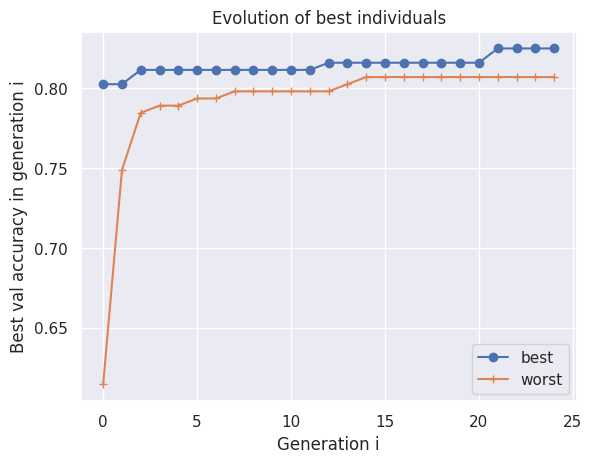

In [26]:
plt.plot(eve.best_solutions, 'o-', label="best")
plt.plot(eve.worst_solutions, '+-', label="worst")
plt.ylabel("Best val accuracy in generation i")
plt.xlabel("Generation i")
plt.title("Evolution of best individuals")
plt.legend()

For the titanic validation dataset and the chosen features we can see that some score above 0.8 is best.

# Understanding the evolution of hyperparameters <a class="anchor" id="de_hyperpar_evolution"></a>

One part I find most interesting in using DE for hyperparameter search is to observe the evolution of hyperparameters and their related score or loss values:

In [27]:
plt.rcParams["animation.html"] = "jshtml" 
    
class ShowHyperparameterEvolution:

    def __init__(self, model):
        self.eve = model
        self.num_generations = len(self.eve.all_generations)
        
        self.fig, self.ax = plt.subplots(1,3,figsize=(20,5))
        
        self.ax[0].set_xlim([0, 500])
        self.ax[0].set_ylim([0, 500])
        self.ax[0].set_xlabel("Neurons in layer 1")
        self.ax[0].set_ylabel("Neurons in layer 2")
        
        self.ax[1].set_xlim([0,1])
        self.ax[1].set_ylim([0,1])
        self.ax[1].set_xlabel("Dropout layer 1")
        self.ax[1].set_ylabel("Dropout layer 2")
        
        self.ax[2].set_xlim([0,0.8])
        self.ax[2].set_ylim([0,25])
        self.ax[2].set_xlabel("Learning rate")
        self.ax[2].set_ylabel("Number of epochs")
        
        
    
    def show(self):
        self.ani = animation.FuncAnimation(self.fig, self.update,
                                           init_func=self.init_fun,
                                           frames=self.num_generations,
                                           interval=900,
                                           blit=False,
                                           repeat=False)
        #Writer = animation.writers['ffmpeg']
        #writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
        #self.ani.save('example.mp4', writer=writer)
        plt.close()
        return self.ani

    def get_data(self, generation):
        data = np.zeros(shape=(len(generation), 6))
        for i in range(len(generation)):
            data[i,0] = generation[i].parameters["num_neurons_1"]["current"]
            data[i,1] = generation[i].parameters["num_neurons_2"]["current"]
            data[i,2] = generation[i].parameters["dropout_1"]["current"]
            data[i,3] = generation[i].parameters["dropout_2"]["current"]
            data[i,4] = generation[i].parameters["lr"]["current"]
            data[i,5] = generation[i].parameters["epochs"]["current"]
        return data
        
    def update(self, i):
        """Update the scatter plot."""
        generation = self.eve.all_generations[i]
        data = self.get_data(generation)
        if i==0:
            self.scat1 = self.ax[0].scatter(data[:, 0], data[:, 1], c="mediumseagreen", marker='o', s=15) 
            self.scat2 = self.ax[1].scatter(data[:, 2], data[:, 3], c="red", marker="o", s=15)
            self.scat3 = self.ax[2].scatter(data[:, 4], data[:, 5], c="purple", marker="o", s=15)
        else:
            self.scat1.set_offsets(data[:,0:2])
            self.scat2.set_offsets(data[:,2:4])
            self.scat3.set_offsets(data[:,4:6])
        #return self.scat1,

    def init_fun(self):
        return [self.ax]

In [28]:
gwc = ShowHyperparameterEvolution(eve)
gwc.show()

### Insights

* We can see that DE finds several solutions that are similar good with close scores. 
* Furthermore we can see an interesting pattern: 
    * The number of neurons in layer 1 seem to be more peaked than in layer 2.
    * The dropout rate of layer 1 spreads a lot while the rates of layer 2 are more dense. 
    * The number of epochs vary quite a lot! 

Probably there is a dependency between these hyperparameters that we can use to improve our optimization and for a fruitful rule of thumb. 